#Install Supervision and Ultralytics (Yolo V8)

In [3]:
!pip install supervision ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.9/645.9 kB 10.0 MB/s eta 0:00:00


set home var

In [4]:
import numpy as np
import os
HOME = os.getcwd()
print(HOME)

/content


download subway video

In [5]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz" -O subway.mp4 && rm -rf /tmp/cookies.txt


/content
--2023-11-28 08:40:22--  https://docs.google.com/uc?export=download&confirm=t&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz
Resolving docs.google.com (docs.google.com)... 108.177.98.139, 108.177.98.102, 108.177.98.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.98.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2ioi0l6sg6qltljh8edlombckfbefv0e/1701160800000/04309230031174164349/*/1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz?e=download&uuid=a891c7e9-2f12-4406-b3a1-8cae57b87ca4 [following]
--2023-11-28 08:40:22--  https://doc-00-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2ioi0l6sg6qltljh8edlombckfbefv0e/1701160800000/04309230031174164349/*/1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz?e=download&uuid=a891c7e9-2f12-4406-b3a1-8cae57b87ca4
Resolving doc-00-ag-docs.googleusercontent.com (doc-00-ag-docs.googleusercontent.com)... 74.125.

In [6]:
SUBWAY_VIDEO_PATH = f"{HOME}/subway.mp4"

#Get Image with label using YoloV8 + Supervision

100%|██████████| 6.23M/6.23M [00:00<00:00, 117MB/s]



0: 1280x736 12 persons, 1 backpack, 2 handbags, 1 teddy bear, 204.6ms
Speed: 36.7ms preprocess, 204.6ms inference, 24.6ms postprocess per image at shape (1, 3, 1280, 736)


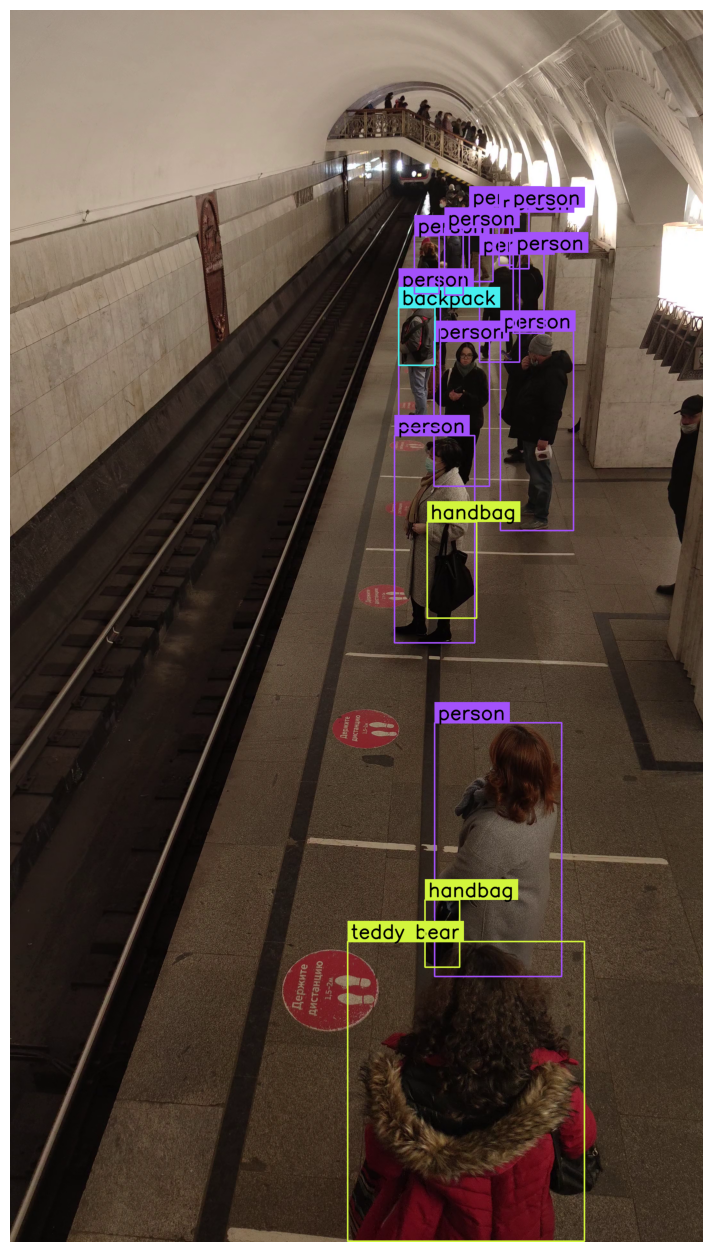

In [7]:
import supervision as sv
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

# extract video frame
generator = sv.get_video_frames_generator(SUBWAY_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)
label_annotator = sv.LabelAnnotator()


labels = [
    results.names[class_id]
    for class_id
    in detections.class_id
]

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
box_annotator = box_annotator.annotate( scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(frame, (16, 16))

#Get Detectron 2

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-0gcnq5t2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-0gcnq5t2
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6118657 sha256=e01ddc88399d9c0baceb8a288af47

In [8]:
from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

detectron2: 0.6


In [11]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:01, 157MB/s]                           


In [12]:
from detectron2.data import MetadataCatalog

# extract video frame
generator = sv.get_video_frames_generator(SUBWAY_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'handbag', 'backpack', 'handbag', 'person', 'stop sign', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


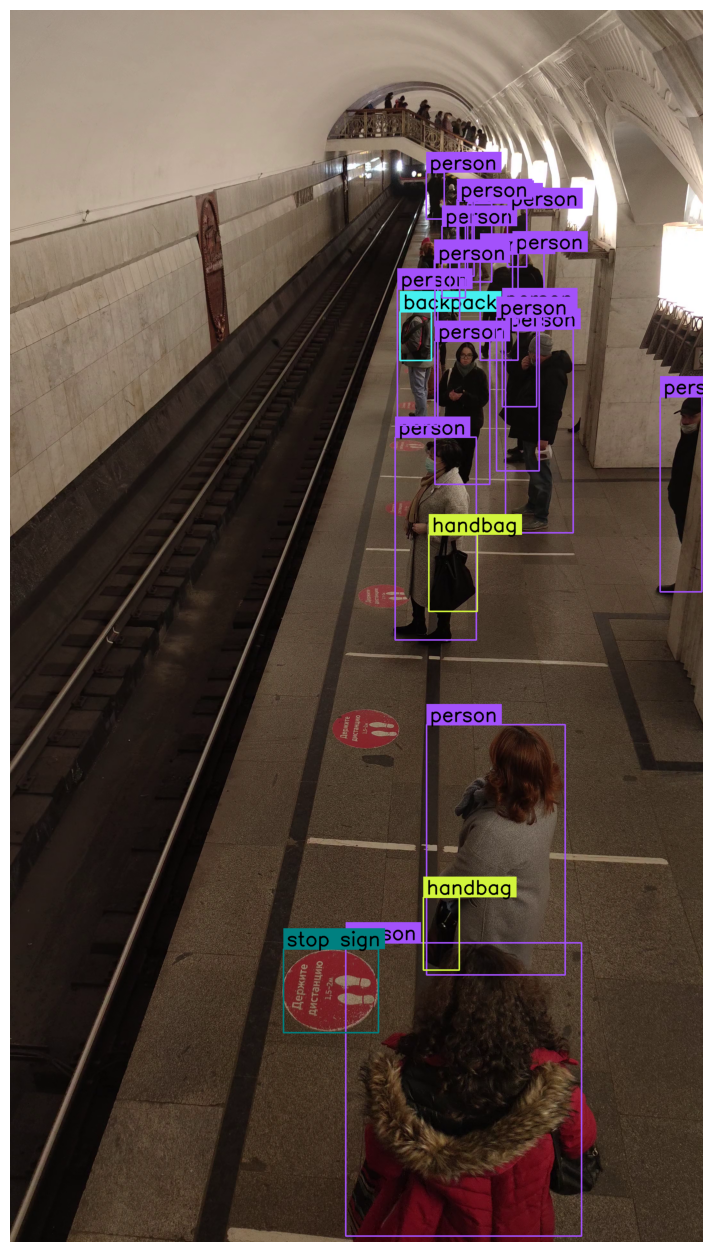

In [13]:
outputs = predictor(frame) #using detectron
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)


#get the labels form detectron
pred_classes = outputs['instances'].pred_classes.cpu().tolist() #list fo class id
class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes #get our dataset
pred_class_names = list(map(lambda x: class_names[x], pred_classes)) #get the names
print(pred_class_names)


# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=detections,labels=pred_class_names)



%matplotlib inline
sv.plot_image(frame, (16, 16))

In [17]:
sv.VideoInfo.from_video_path(SUBWAY_VIDEO_PATH)

VideoInfo(width=2160, height=3840, fps=29, total_frames=1298)

#polygone on image and tracking

In [14]:
# initiate polygon zone
polygon = np.array([
    [200, 3840],
    [1300, 600],
    [1325, 600],
    [550, 3840]
])
video_info = sv.VideoInfo.from_video_path(SUBWAY_VIDEO_PATH)
zone = sv.PolygonZone(
    polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(
    zone=zone, color=sv.Color.red(), thickness=10, text_thickness=10, text_scale=4)

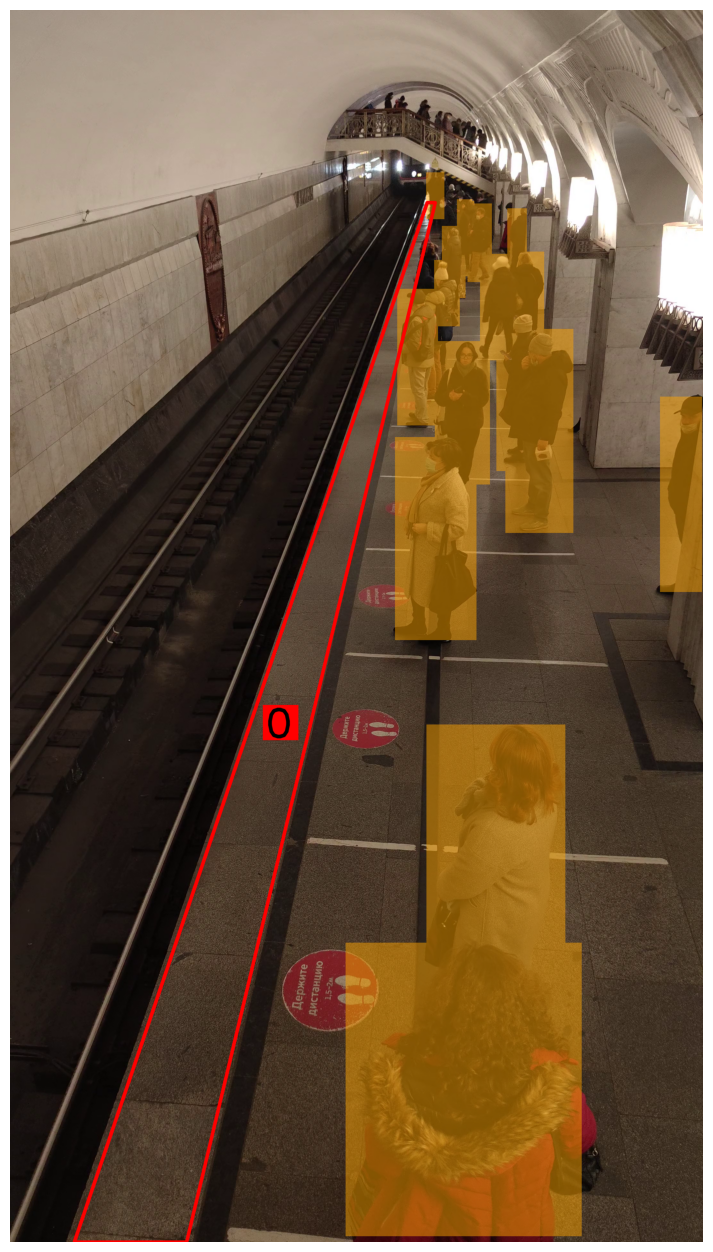

In [15]:
# extract video frame
generator = sv.get_video_frames_generator(SUBWAY_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
outputs = predictor(frame)
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
box_mask_annotator = sv.BoxMaskAnnotator(color=sv.Color.from_hex("#FFA500"))
frame = box_mask_annotator.annotate(scene=frame, detections=detections)
#box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2,color=sv.Color.from_hex("#FFA500"))
#frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)

frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.plot_image(frame, (16, 16))

#Video Tracking with polygon

In [16]:
from IPython import display
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [200, 3840],
    [1300, 600],
    [1325, 600],
    [550, 3840]
])
video_info = sv.VideoInfo.from_video_path(SUBWAY_VIDEO_PATH)
zone = sv.PolygonZone(
    polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(
    zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)


def process_frame(frame: np.ndarray, i: int) -> np.ndarray:
    print('frame', i)
    # detect
    outputs = predictor(frame)
    detections = sv.Detections(
        xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
        confidence=outputs["instances"].scores.cpu().numpy(),
        class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
    )
    detections = detections[detections.class_id == 0]
    zone.trigger(detections=detections)

    # annotate
    box_annotator = sv.BoxAnnotator(
        thickness=4, text_thickness=4, text_scale=2)
    frame = box_annotator.annotate(
        scene=frame, detections=detections, skip_label=True)
    frame = zone_annotator.annotate(scene=frame)

    return frame


sv.process_video(source_path=SUBWAY_VIDEO_PATH,
                 target_path=f"{HOME}/subway-result.mp4", callback=process_frame)

display.clear_output()